In [1]:
import torch
from torch import nn

In [2]:
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/kaggle/input/carvana-image-masking-png/train_images/"
TRAIN_DIR_MASK = "/kaggle/input/carvana-image-masking-png/train_masks/"
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_WORKERS = 2
NUM_EPOCHS = 200
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_UNET = "unetattention.pth.tar"

both_transform = A.Compose(
    [A.Resize(width=256, height=256), A.HorizontalFlip(p=0.5)], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        ToTensorV2(),
    ]
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class CityDataset(Dataset):
    def __init__(self, root_dir, mask_dir):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.list_file = os.listdir(self.root_dir)

        
    def __len__(self):
        return len(self.list_file)
    

    def __getitem__(self, index):
        img_file = self.list_file[index]
        img_path = os.path.join(self.root_dir, img_file)
        mask_path = os.path.join(self.mask_dir, img_file)
        input_img = np.array(Image.open(img_path))
        target_img = np.array(Image.open(mask_path[:-3] + "png"))
        
        augmentations = both_transform(image=input_img, image0=target_img)
        input_img, target_img = augmentations['image'], augmentations['image0']
        
        input_img = transform_only_input(image=input_img)['image']
        target_img = transform_only_mask(image=target_img)['image']
        
        return input_img, target_img

(tensor([  0., 255.]), tensor([46798, 18738]))


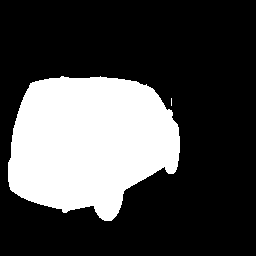

In [4]:
from torch.utils.data import DataLoader
te_dataset = CityDataset(root_dir=TRAIN_DIR, mask_dir=TRAIN_DIR_MASK)
te_loader = DataLoader(te_dataset, batch_size=1, shuffle=True, num_workers=1)

batch= iter(te_loader)
images, labels = next(batch)
import torchvision.transforms as T
labels[0].shape
print(torch.unique(labels[0].float() * 255, return_counts=True))
transform = T.ToPILImage()
transform(labels[0].float())

In [5]:
import torch
from torchvision.utils import save_image

def save_some_examples(unet, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    unet.eval()
    with torch.no_grad():
        y_fake = unet(x)
        y_fake[y_fake > 0.5] = 1  # remove normalization#
        y_fake[y_fake <= 0.5] = 0  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        save_image(y.float() , folder + f"/label_{epoch}.png")
    unet.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load("/kaggle/working/" + checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        s = self.conv(x)
        p = self.pool(s)
        return s, p

    
class AttentionGate(nn.Module):
    def __init__(self, in_channels_input, in_channels_skip, out_channels):
        super().__init__()
        self.input_conv = nn.Sequential(
            nn.Conv2d(in_channels_input, out_channels, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(out_channels)
        )
        
        self.skip_conv = nn.Sequential(
            nn.Conv2d(in_channels_skip, out_channels, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(out_channels)
        )
        
        self.relu = nn.ReLU(inplace=True)
        
        self.output_conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0, stride=1),
            nn.Sigmoid()
        )
        
    def forward(self, inputs, skips):
        x = self.input_conv(inputs)
        s = self.skip_conv(skips)
        out = self.relu(x + s)
        out = self.output_conv(out)
        return out * skips
        
class DecoderBlock(nn.Module):
    def __init__(self, in_channels_input, in_channels_skip, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.attention = AttentionGate(in_channels_input, in_channels_skip, out_channels)
        self.c1 = ConvBlock(in_channels_input + out_channels, out_channels)
        
        
    def forward(self, x, skip):

        x = self.up(x)
        skip = self.attention(x, skip)
        x = torch.cat([x, skip], dim=1)
        return self.c1(x)
        
    
class AttentionUnet(nn.Module):
    def __init__(self, in_channels, out_channels, feature=64):
        super().__init__()
        self.e1 = EncoderBlock(in_channels, feature)
        self.e2 = EncoderBlock(feature, feature * 2)
        self.e3 = EncoderBlock(feature * 2, feature * 4)
        
        self.b1 = ConvBlock(feature * 4, feature * 8)
        
        self.d1 = DecoderBlock(feature * 8, feature * 4, feature * 4)
        self.d2 = DecoderBlock(feature * 4, feature * 2, feature * 2)
        self.d3 = DecoderBlock(feature * 2, feature, feature)
    
        self.final = nn.Conv2d(feature, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x):
        s, p = self.e1(x)
        s2, p2 = self.e2(p)
        s3, p3 = self.e3(p2)
        
        b1 = self.b1(p3)
        
        d1 = self.d1(b1, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s)
        
        return self.final(d3)
        
x = torch.randn((5, 3, 64, 64))
model = AttentionUnet(3, 3)
print(model(x).shape)

torch.Size([5, 3, 64, 64])


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
print(SAVE_MODEL)
torch.backends.cudnn.benchmark = True

def train_fn(unet, train_loader, opt, loss_fn, scaler):
    loop = tqdm(train_loader, leave=True)
    
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.float().to(DEVICE)
        
        #Train Discriminator
        with torch.cuda.amp.autocast():
            segment = unet(x)
            loss = loss_fn(segment, y)
        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        loop.set_postfix(loss=loss.item())

        
        
def main():
    unet = AttentionUnet(in_channels=3, out_channels=1).to(DEVICE)
    opt=optim.Adam(unet.parameters(), lr=LEARNING_RATE)
    
    loss = nn.BCEWithLogitsLoss()
    
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_UNET, unet, opt, LEARNING_RATE)
        
    train_dataset = CityDataset(root_dir=TRAIN_DIR, mask_dir=TRAIN_DIR_MASK)
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(1))
    scaler = torch.cuda.amp.GradScaler()
    
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    for epoch in range(NUM_EPOCHS):
        train_fn(unet, train_loader, opt, loss, scaler)
        
        if(SAVE_MODEL and epoch % 5 == 0):
            save_checkpoint(unet, opt, filename=CHECKPOINT_UNET)
        if epoch % 5 == 0:
            save_some_examples(unet, val_loader, epoch, folder='.')

main()

True


100%|██████████| 255/255 [02:56<00:00,  1.44it/s, loss=0.119]


=> Saving checkpoint


100%|██████████| 255/255 [02:43<00:00,  1.56it/s, loss=0.0204]


=> Saving checkpoint


100%|██████████| 255/255 [02:42<00:00,  1.57it/s, loss=0.00916]


=> Saving checkpoint


 58%|█████▊    | 148/255 [01:35<01:09,  1.55it/s, loss=0.00728]
